# Exploring Character Classification
The image classification poses a great challenge when the dataset is highly imbalanced and the variation is high as discussed in the previous section of Data Exploration. The following section explores the classification part of the data by using RESNET34 as the backbone for classification. The study here is to explore the feasibility of training the data first by looking at the dominant characters. We study 50%, 80% and the full part of the dataset for the classification. We also explore the effectiveness of data augmentation to the data with lower frequency count. We use albumentations for fast image augmentation which will only distort the image with translation, scaling, rotation and deformation. For the treatment of imbalance dataset, we set a weight in the data sampler to increase the sampling of those characters of lower frequency and apply image augmentation on the fly to the image. This is to hope that more variation of the character can be created and the model can learn those more effectively.

In [0]:
import torch
from torch import nn, optim
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import Sampler
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import sys,os
import inspect
import time
import cv2
import pandas as pd
import numpy as np
from albumentations import (
    HorizontalFlip, ShiftScaleRotate,Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion,
    MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, ElasticTransform, Flip, OneOf
)
from albumentations import Compose as Comp
from imgaug import augmenters as iaa
import warnings
warnings.filterwarnings("ignore")
data_dir="./"


From the section on Data exploration, we gathered the information about the count of each character. We use index mapping to map a list of selected characters for training. The selected characters can be dominant characters or non-dominant characters. The different sets can be used for additional image augmentation and analysis.

In [0]:
csv_info=pd.read_csv("./chars_freq.csv")
csv_info_sorted=csv_info.sort_values("count", ascending=False)
chr_freq=list(csv_info_sorted["count"])
#dominant character list is extracted from the sorted count
dominant_char=list(csv_info_sorted.iloc[0:29]['char'])
labeldict={}
domlen=len(dominant_char)
charlen=len(csv_info_sorted)
for i in range(charlen):
  labeldict.update({csv_info_sorted.iloc[i]['char']:i})
#print(labeldict)

# We maintain a full info list of characters
infocsv=pd.read_csv('./info_csv.csv')
full_ind=list(range(len(infocsv)))
def dominant_indexes(dom_char,infotable,save_tocsv="./dom.csv"):
    dom_list=[]; ndom_list=[]
    dom_df=infotable
    for index, row in infotable.iterrows():
        if row['char'] in dom_char:
            dom_list.append(index)
        else:
            ndom_list.append(index)
        if index%100000==0:
            print("Index: ",index)
    dom_df=dom_df.drop(dom_df.index[ndom_list])
    dom_df.to_csv(save_tocsv)
    return(dom_list)
#dominant character mapping index for dataset generator
dom_ind=dominant_indexes(dominant_char,infocsv)

Index:  0
Index:  100000
Index:  200000
Index:  300000
Index:  400000
Index:  500000
Index:  600000


In [0]:
# check the sorted heading
csv_info_sorted.head(29)


,Unnamed: 0,char,count,japanesechar
4,4,U+306B,24685,に
5,5,U+306E,24136,の
55,55,U+3057,22209,し
22,22,U+3066,20569,て
10,10,U+3068,16588,と
28,28,U+3092,15743,を
0,0,U+306F,14759,は
25,25,U+304B,14342,か
70,70,U+308A,14184,り
38,38,U+306A,13750,な


In [0]:
#From the mapping indexes of the extracted set, split the set into train and test set
#This in fact a indexing list and not the actual data which is very lightweight
length=len(dom_ind)
trainlen=int(0.8*length)
testlen=length-trainlen
np.random.shuffle(dom_ind)
train_indmap=dom_ind[0:trainlen-1]
test_indmap=dom_ind[trainlen:]


In [0]:
full_ind=list(range(len(infocsv)))

We create a pyorch dataset generator to create a single data pair. The data loader will request for the data during the run. The custom dataset generator uses the indexing list to get the data of interest. An image augmentation option can also be used to control whether we requires image augmentation. Each data is processed to a single channel and threshold to produce binary image.

In [0]:
class kuzu_dataset(Dataset):
  def __init__(self, indmap, df, imgpath, labeldict,augment=False,transform=None):
    self.df=df
    self.transform = transform
    self.indmap=indmap
    self.imgpath=imgpath
    self.labeldict=labeldict
    self.augment=augment

  def __len__(self):
    return len(self.indmap)

  def readimg2bw(self,filename):
    img=cv2.imread(filename)
    img0=255-cv2.resize(img[:,:,0],(224,224))
    if self.augment:
        aug=self.augment_scr(0.75)
        img0=aug(image=img0)['image']
    #ret, otsu = cv2.threshold(img00,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    _,th = cv2.threshold(img0,127,255,cv2.THRESH_BINARY)
    return th

  def augment_scr(self,p=.5):
    return Comp([
        ShiftScaleRotate(shift_limit=0.05, scale_limit=0.15, rotate_limit=8, border_mode=0,  p=.9),
        OneOf([
            Blur(blur_limit=7,p=0.25),
            MedianBlur(blur_limit=7,p=0.25)
        ], p=0.5),
        OneOf([
            OpticalDistortion(border_mode=0, p=0.1),
            GridDistortion(border_mode=0, p=.1),
            ElasticTransform(border_mode=0, p=.1)
        ], p=0.3),
    ], p=p)

  def __getitem__(self,ind):
    indm=self.indmap[ind]
    imagename=self.df.iloc[indm]['imagename']
    data_single=self.readimg2bw(self.imgpath+imagename)
    char=self.df.iloc[indm]['char']
    label=self.labeldict[char]
    if self.transform:
      data_single=self.transform(data_single)
    sample=(data_single,label)
    return sample

  def __getlabel__(self,ind):
    indm=self.indmap[ind]
    char=self.df.iloc[indm]['char']
    label=self.labeldict[char]
    return label




In [0]:
# test out the dataset generator
imgpath=data_dir+"kmnist/images/"
kuzu=kuzu_dataset(train_indmap,infocsv,imgpath,labeldict,augment=True)


In [0]:
csv_info_sorted.head(20)

,Unnamed: 0,char,count,japanesechar
4,4,U+306B,24685,に
5,5,U+306E,24136,の
55,55,U+3057,22209,し
22,22,U+3066,20569,て
10,10,U+3068,16588,と
28,28,U+3092,15743,を
0,0,U+306F,14759,は
25,25,U+304B,14342,か
70,70,U+308A,14184,り
38,38,U+306A,13750,な


Character label:  9


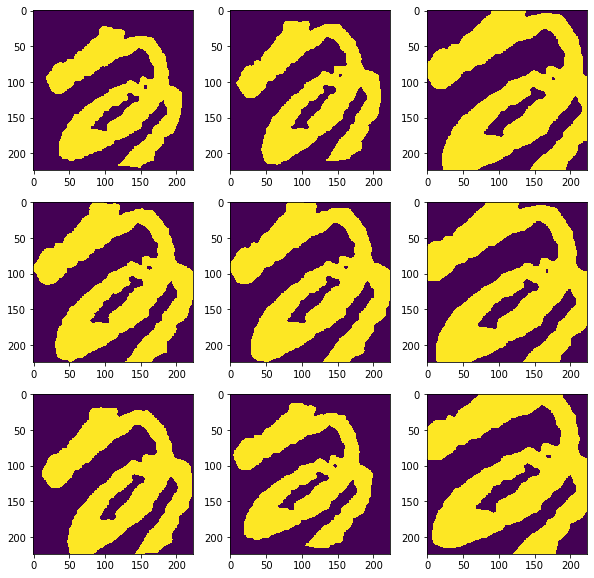

In [0]:
# Check that out dataset generator generates the image according to the indexing list e.g. dominant chars
f, a = plt.subplots(3,3,figsize=(10,10))

for i in range(3):
    for j in range(3):
        k,b=kuzu.__getitem__(2500)
        #plt.imshow(k)
        a[i,j].imshow(k)
print("Character label: ", b)

In [0]:
#use 1000 random samples to obtain the mean and std of the data distribution 
#this is to normalise the data
sample=1000
sample_ind=np.random.randint(sample,size=sample)
datas=[]
for _,s in enumerate(sample_ind):
    d,_=kuzu.__getitem__(s)
    datas.append(d)
datas=np.array(datas)
mean=np.mean(datas)
std=np.std(datas)
print("mean: ",mean," std: ",std)

mean:  79.3279254025829  std:  118.04957106648406


In [0]:
class KmnistResNet(ResNet):
    def __init__(self):
        super(KmnistResNet, self).__init__(BasicBlock, [3, 4, 6, 3], num_classes=29)
        self.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)      
    def forward(self, x):
        return torch.softmax(super(KmnistResNet, self).forward(x), dim=-1)
# RESNET 101 [3, 4, 23, 3] [3, 4, 6, 3]

In [0]:
class dataset_sampler(Sampler):
    def __init__(self,kuzu_dataset,char_freq):
        self.ind = list(range(len(kuzu_dataset)))
        self.nsample = len(kuzu_dataset)
        classweights = [1.0/char_freq[kuzu_dataset.__getlabel__(i)] for i in self.ind]
        self.classweights = torch.DoubleTensor(classweights)

    def __iter__(self):
        return (self.ind[i] for i in torch.multinomial(self.classweights, self.nsample, replacement=True))

    def __len__(self):
        return self.nsample

In [0]:
def dataloaders(trg_batch_size, tst_batch_size,mean,std):
    data_transform = Compose([ToTensor(), Normalize((mean/255,), (std/255,))])
    trg_loader = DataLoader(kuzu_dataset(train_indmap,infocsv,imgpath,labeldict,transform=data_transform),batch_size=trg_batch_size, shuffle=False)
    tst_loader = DataLoader(kuzu_dataset(test_indmap,infocsv,imgpath,labeldict,transform=data_transform),batch_size=tst_batch_size, shuffle=False)
    return tst_loader, trg_loader
def dataloaders_aug(trg_batch_size, tst_batch_size,mean,std,char_freq):
    data_transform = Compose([ToTensor(), Normalize((mean/255,), (std/255,))])
    trg_dataset=kuzu_dataset(train_indmap,infocsv,imgpath,labeldict,augment=True,transform=data_transform)
    trg_loader = DataLoader(trg_dataset,sampler=dataset_sampler(trg_dataset,char_freq),batch_size=trg_batch_size, shuffle=False)
    tst_loader = DataLoader(kuzu_dataset(test_indmap,infocsv,imgpath,labeldict,transform=data_transform),batch_size=tst_batch_size, shuffle=False)
    return tst_loader, trg_loader

In [0]:
#check the loader
tst_loader, trg_loader=dataloaders(256, 256,mean,std)
batches = len(tst_loader)
print(batches)

264


In [0]:
def calculate_metric(metric_fn, true_y, pred_y):
    if "average" in inspect.getfullargspec(metric_fn).args:
        return metric_fn(true_y, pred_y, average="macro")
    else:
        return metric_fn(true_y, pred_y)


In [0]:
#Training and validate function that reuse model for further training or cross-training
# return model and losses, accuracies records

def train_validate(epochs,tst_loader,trg_loader,model):
    starttime = time.time()
    losses=[]
    lossfunc = nn.CrossEntropyLoss()
    optimizer = optim.Adadelta(model.parameters())
    batches = len(trg_loader)
    tstbatches = len(tst_loader)
    tloss=[]
    titer=[]
    acc=[]
    eph=[]
    for epoch in range(epochs):
        totalloss=0
        model.train()
    
        for i, data in enumerate(trg_loader):
            X, y = data[0].to(device), data[1].to(device)
            model.zero_grad()
            outputs = model(X)
            loss = lossfunc(outputs, y)
            loss.backward()
            optimizer.step()
            closs = loss.item()
            totalloss += closs
            if i%100==0:
                tl=totalloss/(i+1)
                print("Iter: ",i, " Loss: ",tl)
                tloss.append(tl)
                titer.append((epoch)*batches+i)
        torch.cuda.empty_cache()
        tstlosses = 0
        precision, recall, f1, accuracy = [], [], [], []
        model.eval()
        with torch.no_grad():
            for i, data in enumerate(tst_loader):
                X, y = data[0].to(device), data[1].to(device)
                outputs = model(X)
                tstlosses += lossfunc(outputs, y)
                predicted_classes = torch.max(outputs, 1)[1]
                for acc,metric in zip((precision, recall, f1, accuracy),(precision_score, recall_score, f1_score, accuracy_score)):
                    acc.append(calculate_metric(metric, y.cpu(), predicted_classes.cpu()))
        print(f"Run Epoch {epoch+1}/{epochs}") 
        print(f"Training loss: {totalloss/batches}")
        print(f"Testing loss: {tstlosses/tstbatches}")
        print(f"Precision: {sum(precision)/tstbatches}")
        print(f"Recall: {sum(recall)/tstbatches}")
        print(f"F1: {sum(f1)/tstbatches}")
        print(f"Accuracy: {sum(accuracy)/tstbatches}")
        acc.append(sum(accuracy)/tstbatches)
        eph.append(epoch)
    print(f"Total time taken: {time.time()-starttime}s")
    return model,(tloss,titer,acc,epoch)

**Normal training**

First normal training of the 29 dominant characters without any image augmentation or sample weighting. The accuracy did not improve after 13 epoch.

Obtained an Accuracy: 0.9746659332076608


In [0]:
#create both training and testing data loader which specify whether augmentation and class weighting will be used

#First training of 29 dominant character dataset (about 340k samples)
#Total 13 epochs till it doesnt improve
batchsize=256
tst_loader, trg_loader = dataloaders(batchsize,batchsize,mean,std)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model=KmnistResNet().to(device)
model,p=train_validate(10,tst_loader,trg_loader,model)

Iter:  0  Loss:  3.36711049079895
Iter:  100  Loss:  3.203361397922629
Iter:  200  Loss:  3.138208923055165
Iter:  300  Loss:  3.0896776641326094
Iter:  400  Loss:  3.047342820060521
Iter:  500  Loss:  3.017817244082392
Iter:  600  Loss:  2.995711548752872
Iter:  700  Loss:  2.9710074460795535
Iter:  800  Loss:  2.9452226158980275
Iter:  900  Loss:  2.9200155174030975
Iter:  1000  Loss:  2.898279935806305
Run Epoch 1/10
Training loss: 2.887992469198776
Testing loss: 2.8096461296081543
Precision: 0.48087220102255845
Recall: 0.49408929622135356
F1: 0.4488371090878896
Accuracy: 0.6220570372238742
Iter:  0  Loss:  2.7077794075012207
Iter:  100  Loss:  2.693204084245285
Iter:  200  Loss:  2.685940715210948
Iter:  300  Loss:  2.6800810110529394
Iter:  400  Loss:  2.6717295022379433
Iter:  500  Loss:  2.664200108446285
Iter:  600  Loss:  2.6588842154739303
Iter:  700  Loss:  2.652640745065012
Iter:  800  Loss:  2.6468528858880127
Iter:  900  Loss:  2.639925826535241
Iter:  1000  Loss:  2.6325

In [0]:
torch.save(model.state_dict(), "./kuzu_29.pth")
import pickle
with open('./log_d29.pkl', 'wb') as f:
    pickle.dump(p, f)

In [0]:
batchsize=256
tst_loader, trg_loader = dataloaders(batchsize,batchsize,mean,std)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model=KmnistResNet().to(device)
model.load_state_dict(torch.load("./kuzu_29.pth"))
model,p=train_validate(3,tst_loader,trg_loader,model)

Iter:  0  Loss:  2.4283204078674316
Iter:  100  Loss:  2.4484048007738473
Iter:  200  Loss:  2.447988428286652
Iter:  300  Loss:  2.448523453303746
Iter:  400  Loss:  2.4485642107347596
Iter:  500  Loss:  2.4488683836664746
Iter:  600  Loss:  2.449098769122868
Iter:  700  Loss:  2.4489921445343192
Iter:  800  Loss:  2.4489217268840204
Iter:  900  Loss:  2.4490022770440274
Iter:  1000  Loss:  2.4490739458448045
Run Epoch 1/3
Training loss: 2.4491791054606438
Testing loss: 2.450913906097412
Precision: 0.9775845684205863
Recall: 0.9705076577612965
F1: 0.9715310897761821
Accuracy: 0.9746601252743556
Iter:  0  Loss:  2.4249980449676514
Iter:  100  Loss:  2.4474454256567624
Iter:  200  Loss:  2.4465016583305093
Iter:  300  Loss:  2.446889495532774
Iter:  400  Loss:  2.4469529399253482
Iter:  500  Loss:  2.4473709888800887
Iter:  600  Loss:  2.447416862909885
Iter:  700  Loss:  2.447127039864468
Iter:  800  Loss:  2.4470243081915544
Iter:  900  Loss:  2.4468931474378715
Iter:  1000  Loss:  2.

In [0]:
torch.save(model.state_dict(), "./kuzu_29_2.pth")
import pickle
with open('./log_d29_2.pkl', 'wb') as f:
    pickle.dump(p, f)

In [0]:
#with open('./log_d29.pkl', 'rb') as f:
#     pp = pickle.load(f)

**Augmentation and sample weighting**

Augmenting the dataset with image transformation and sample weighting on the fly. The dataset object will handle thse tasks.

Obtained an Accuracy: 0.9820638573969839

Improved by 0.8%.

In [0]:
#Augmentating  data with augment option. Simialar 29 dominant character set
batchsize=256
tst_loader, trg_loader = dataloaders_aug(batchsize,batchsize,mean,std,chr_freq)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model=KmnistResNet().to(device)
model_aug,p_aug=train_validate(10,tst_loader,trg_loader,model)

Iter:  0  Loss:  3.368483066558838
Iter:  100  Loss:  3.2731250016996176
Iter:  200  Loss:  3.202259606982938
Iter:  300  Loss:  3.155455761177595
Iter:  400  Loss:  3.11566012339699
Iter:  500  Loss:  3.083656248218285
Iter:  600  Loss:  3.0562022374989386
Iter:  700  Loss:  3.0309359217846445
Iter:  800  Loss:  3.00991680797715
Iter:  900  Loss:  2.9889701656443166
Iter:  1000  Loss:  2.9677527903557777
Run Epoch 1/10
Training loss: 2.956032778503317
Testing loss: 2.833322286605835
Precision: 0.5100151923371467
Recall: 0.6039007111603684
F1: 0.5158988655789114
Accuracy: 0.5970572031648258
Iter:  0  Loss:  2.76928973197937
Iter:  100  Loss:  2.7216055747305994
Iter:  200  Loss:  2.7124014434529773
Iter:  300  Loss:  2.7007998263717092
Iter:  400  Loss:  2.6927540112017394
Iter:  500  Loss:  2.6864186147015965
Iter:  600  Loss:  2.6816259680095804
Iter:  700  Loss:  2.6779619113524866
Iter:  800  Loss:  2.6729120437274414
Iter:  900  Loss:  2.6680821181666707
Iter:  1000  Loss:  2.6639

In [0]:
torch.save(model_aug.state_dict(), "./kuzu_29_aug.pth")
import pickle
with open('./log_d29_aug.pkl', 'wb') as f:
    pickle.dump(p_aug, f)

In [0]:
batchsize=256
tst_loader, trg_loader = dataloaders(batchsize,batchsize,mean,std)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_aug=KmnistResNet().to(device)
model_aug.load_state_dict(torch.load("./kuzu_29_aug.pth"))
model_aug,p_aug=train_validate(6,tst_loader,trg_loader,model_aug)

Iter:  0  Loss:  2.4546544551849365
Iter:  100  Loss:  2.474271821503592
Iter:  200  Loss:  2.473717309942293
Iter:  300  Loss:  2.473692832991134
Iter:  400  Loss:  2.4736299936908144
Iter:  500  Loss:  2.4735919896238103
Iter:  600  Loss:  2.473721752547583
Iter:  700  Loss:  2.473355233414197
Iter:  800  Loss:  2.4732736862554088
Iter:  900  Loss:  2.473136011688876
Iter:  1000  Loss:  2.473269492357999
Run Epoch 1/6
Training loss: 2.4733967939109514
Testing loss: 2.4747533798217773
Precision: 0.9153634168342489
Recall: 0.9375744761432641
F1: 0.9213953398327925
Accuracy: 0.950317140815279
Iter:  0  Loss:  2.4543986320495605
Iter:  100  Loss:  2.471226194117329
Iter:  200  Loss:  2.470666319576662
Iter:  300  Loss:  2.4701773716365776
Iter:  400  Loss:  2.470091625342048
Iter:  500  Loss:  2.4700578886591744
Iter:  600  Loss:  2.470037007688881
Iter:  700  Loss:  2.4697713481206525
Iter:  800  Loss:  2.469693284802669
Iter:  900  Loss:  2.4697260536443646
Iter:  1000  Loss:  2.469958

In [0]:
torch.save(model_aug.state_dict(), "./kuzu_29_aug2.pth")
import pickle
with open('./log_d29_aug2.pkl', 'wb') as f:
    pickle.dump(p_aug, f)

In [0]:
batchsize=256
tst_loader, trg_loader = dataloaders(batchsize,batchsize,mean,std)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_aug=KmnistResNet().to(device)
model_aug.load_state_dict(torch.load("./kuzu_29_aug2.pth"))
model_aug,p_aug=train_validate(3,tst_loader,trg_loader,model_aug)

Iter:  0  Loss:  2.4535393714904785
Iter:  100  Loss:  2.445931040414489
Iter:  200  Loss:  2.445304827903634
Iter:  300  Loss:  2.444563956751776
Iter:  400  Loss:  2.4446437287508997
Iter:  500  Loss:  2.4446925879000667
Iter:  600  Loss:  2.444496958505691
Iter:  700  Loss:  2.444316993256268
Iter:  800  Loss:  2.444098709525538
Iter:  900  Loss:  2.444084420452901
Iter:  1000  Loss:  2.444002498756279
Run Epoch 1/3
Training loss: 2.443955128391584
Testing loss: 2.4475274085998535
Precision: 0.976484469789171
Recall: 0.9751076266604702
F1: 0.9736779432401025
Accuracy: 0.9776754106485416
Iter:  0  Loss:  2.4417312145233154
Iter:  100  Loss:  2.4402886404849515
Iter:  200  Loss:  2.4404982844395424
Iter:  300  Loss:  2.4407636382651092
Iter:  400  Loss:  2.4412461807602956
Iter:  500  Loss:  2.441352266513421
Iter:  600  Loss:  2.4414926249651665
Iter:  700  Loss:  2.441550764989921
Iter:  800  Loss:  2.44148033894552
Iter:  900  Loss:  2.441583569915128
Iter:  1000  Loss:  2.44155749

In [0]:
torch.save(model_aug.state_dict(), "./kuzu_29_aug2.pth")
import pickle
with open('./log_d29_aug3.pkl', 'wb') as f:
    pickle.dump(p_aug, f)

**Full character class set (unsuccessful attempt)**

In order to train the full set of the character classes, we can modify the last fully connected layer of the RESNET34  to 4212 classes. In this way we can use back the pretrained nmodel from the last training using the dominant character set.

In [0]:
class KmnistResNet(ResNet):
    def __init__(self):
        super(KmnistResNet, self).__init__(BasicBlock, [3, 4, 6, 3], num_classes=4212)
        self.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
    def forward(self, x):
        return torch.softmax(super(KmnistResNet, self).forward(x), dim=-1)
# Define the newResnet with 4212 ,  load back the pretrained and  change the last layer and retrain
model0 = KmnistResNet()
model0.fc = nn.Linear(512, 29)
model0.load_state_dict(torch.load("./kuzu_29_aug2.pth"))
#model0.fc = nn.Linear(512, 29)
#model0.load_state_dict(torch.load("./kuzu_29.pth"))
model0.fc = nn.Linear(512, 4212)
model_aug=model0.to(device)
dominant_char=list(csv_info_sorted.iloc[:]['char'])
domlen=len(dominant_char)
dom_ind=dominant_indexes(dominant_char,infocsv,save_tocsv="./dom4212.csv")
length=len(dom_ind)
trainlen=int(0.8*length)
testlen=length-trainlen
np.random.shuffle(dom_ind)
train_indmap=dom_ind[0:trainlen-1]
test_indmap=dom_ind[trainlen:]

Index:  0
Index:  100000
Index:  200000
Index:  300000
Index:  400000
Index:  500000
Index:  600000


In [0]:
batchsize=256
tst_loader, trg_loader = dataloaders_aug(batchsize,batchsize,mean,std,chr_freq)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_aug,p_aug=train_validate(2,tst_loader,trg_loader,model_aug)

Iter:  0  Loss:  8.34570598602295
Iter:  100  Loss:  8.34569526898979
Iter:  200  Loss:  8.345694541931152
Iter:  300  Loss:  8.3456943423249
Iter:  400  Loss:  8.345693433671224
Iter:  500  Loss:  8.345693220873317
Iter:  600  Loss:  8.345693036046084
Iter:  700  Loss:  8.345692386980915
Iter:  800  Loss:  8.345691566610158
Iter:  900  Loss:  8.34569140676653
Iter:  1000  Loss:  8.345690887291115
Iter:  1100  Loss:  8.345690486433288
Iter:  1200  Loss:  8.345690011779633
Iter:  1300  Loss:  8.345689610093489
Iter:  1400  Loss:  8.345689206528375
Iter:  1500  Loss:  8.345688560658658
Iter:  1600  Loss:  8.345687819748354
Iter:  1700  Loss:  8.34568747375237
Iter:  1800  Loss:  8.345686972902458
Iter:  1900  Loss:  8.345685992975852
Iter:  2000  Loss:  8.345685507523186
Iter:  2100  Loss:  8.345682535893232
Run Epoch 1/2
Training loss: 8.345681077085631
Testing loss: 8.345691680908203
Precision: 0.0
Recall: 0.0
F1: 0.0
Accuracy: 0.0
Iter:  0  Loss:  8.345685005187988
Iter:  100  Loss:  

Augmentation with sample weighting doesn't work well with large class and highly imbalanced dataset. It takes much longer to train. Some other methods like few shot learning and data augmentation GAN should be considered.
Training and inference may get higher accuracy if we only consider a smaller class since 95% of the dataset is spanned by 25% of the character class. Some of the detection and classification methods studied so far missed most of the low count or rare characters.

In [0]:
torch.save(model_aug.state_dict(), "./kuzu_4212.pth")
import pickle
with open('./log_d29_aug2.pkl', 'wb') as f:
    pickle.dump(p_aug, f)